# A* Search Algorithm

This program generates a solution for the 8-Puzzle Problem using the A* Search Algorithm. It is implemented using three different heuristic functions:

> a - Number of Tiles in the Wrong Position

> b - Manhattan Distance

> c - Nilsson's Sequence Score

These are referred to in the code as **heuristic functions a, b, and c** respectively.

The start and goal states were configured to follow the image below.

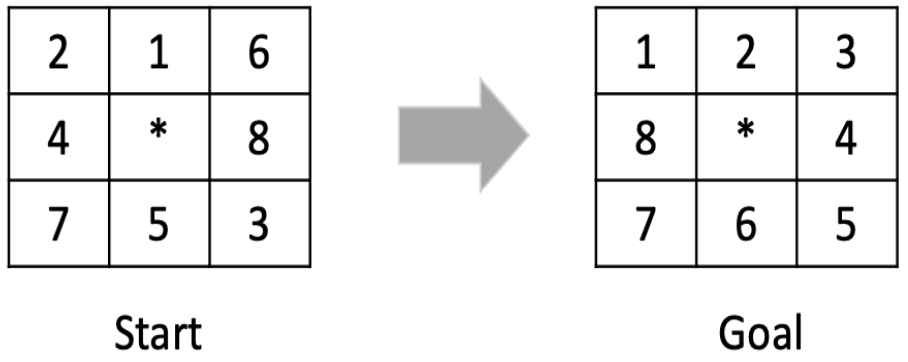

In [ ]:
## Find the correct directory

from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/MEng AI/AI 201/Programming Assignment I


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/MEng AI/AI 201/Programming Assignment I


In [ ]:
##Defines a function to read a text file. The text file follows the formatting defined in the assignment.
##The numbers are converted to integers so we can perform calculations later on.

def read_state_from_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
        start_state = [[int(c) if c != '*' else '*' for c in line.strip()] for line in lines[1:4]]
        goal_state = [[int(c) if c != '*' else '*' for c in line.strip()] for line in lines[5:8]]
    return start_state, goal_state

In [ ]:
##Read the input text file
start_state, goal_state = read_state_from_file("astar_in.txt")
print(start_state, ',', goal_state)

[[2, 1, 6], [4, '*', 8], [7, 5, 3]] , [[1, 2, 3], [8, '*', 4], [7, 6, 5]]


In [ ]:
## For node calculations; the heuristic functions are defined here
class PuzzleNode:
    def __init__(self, state, parent=None, move=None, depth=0, heuristic_type=None, goal_state=None):
        self.state = state
        self.parent = parent
        self.move = move
        self.depth = depth
        self.heuristic_type = heuristic_type
        self.goal_state = goal_state
        self.g_score = depth
        self.h_score = self.heuristic()
        self.f_score = self.g_score + self.h_score
        self.P_score = self.heuristic_b()
        self.S_score = self.heuristic_c()

    def __lt__(self, other):
        return self.f_score < other.f_score

    def __eq__(self, other):
        return self.state == other.state

    def __hash__(self):
        return hash(str(self.state))

    #Chooses which heuristic function to apply in calculating path cost
    def heuristic(self):
        if self.heuristic_type == 'a':
            return self.heuristic_a()
        elif self.heuristic_type == 'b':
            return self.heuristic_b()
        elif self.heuristic_type == 'c':
            return self.heuristic_c()
        else:
            raise ValueError(f"Unexpected heuristic_type value: {self.heuristic_type}")

    ##Define the different heuristic functions
    # Heuristic A: Number of tiles in the wrong position
    def heuristic_a(self):
        wrong_position_count = 0
        for i in range(3):
            for j in range(3):
                if self.state[i][j] != self.goal_state[i][j]:
                    wrong_position_count += 1
        return wrong_position_count

    # Heuristic B: Manhattan distance
    def heuristic_b(self):
        distance = 0
        for i in range(3):
            for j in range(3):
                if self.state[i][j] == '*':
                    continue
                row, col = divmod(int(self.state[i][j]) - 1, 3)
                distance += abs(row - i) + abs(col - j)
        return distance

    # Heuristic C: Nilsson's sequence score
    def heuristic_c(self):
        # Calculate Manhattan distance for each tile (P(n))
        P_score = self.heuristic_b()  # Reuse Manhattan distance calculation from heuristic_b

        # Calculate sequence score (S(n))
        S_score = 0
        for i in range(3):
            for j in range(3):
                if self.state[i][j] != '*':
                    current_tile = int(self.state[i][j])
                    proper_successor = (i * 3 + j + 1) if current_tile != 9 else '*'  # Proper successor for each tile
                    if current_tile != 9 and self.state[i][j] != proper_successor:
                        S_score += 2  # Add 2 for every tile not followed by its proper successor
                    elif current_tile == 5:
                        S_score += 1  # Center tile scores 1

        # Calculate Nilsson's sequence score h(n) = P(n) + 3 * S(n)
        return P_score + 3 * S_score

    #To check whether the node is the goal state
    def is_goal(self, goal_state):
        return self.state == goal_state

    #Generate children nodes based on possible moves
    def generate_children(self):
        children = []
        zero_row, zero_col = self.find_zero()
        moves = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        for dr, dc in moves:
            new_row, new_col = zero_row + dr, zero_col + dc
            if 0 <= new_row < 3 and 0 <= new_col < 3:
                new_state = [row[:] for row in self.state]
                new_state[zero_row][zero_col], new_state[new_row][new_col] = new_state[new_row][new_col], new_state[zero_row][zero_col]
                children.append(PuzzleNode(new_state, parent=self, move=(new_row, new_col), depth=self.depth + 1, heuristic_type=self.heuristic_type, goal_state=self.goal_state))
        return children

   #Identifies the blank tile to be used in generating children nodes
    def find_zero(self):
        for i in range(3):
            for j in range(3):
                if self.state[i][j] == '*':
                    return i, j


In [ ]:
##Applying the A* algorithm in node selection (Refer to Pseudo-code)
def astar_algo(initial_state, goal_state, heuristic_type):
    #Calls the start node 's'
    s = PuzzleNode(initial_state, None, None, 0, heuristic_type, goal_state)
    if s.is_goal(goal_state):
        return [s.state], 1

    #Puts it on a list called open
    OPEN = [s]
    CLOSED = set()
    search_cost = 1

    #while OPEN has elements this will iterate; it will return no solution and the search cost once empty
    while OPEN:
        #find min f value (actual path cost + est from heuristic fxn) and remove this node/state from open list and transfer to closed list
        n = min(OPEN, key=lambda x: x.f_score)
        OPEN.remove(n)
        CLOSED.add(n)

        #if n is the goal, gather all the states/steps/solns that describe the path up to last state and show search cost
        if n.is_goal(goal_state):
            path = []
            while n:
                path.append(n)
                n = n.parent
            return path[::-1], search_cost

        #Generate successors and give them the f, g, h, search cost, P, S values based from parent
        children = n.generate_children()
        for child in children:
            child.g_score = child.depth
            child.h_score = child.heuristic()
            child.f_score = child.g_score + child.h_score
            # Update P_score and S_score
            child.P_score = child.heuristic_b()  # Manhattan distance
            child.S_score = child.heuristic_c() - child.P_score  # Sequence score minus Manhattan distance

            # Increment the search cost for each new node generated
            search_cost += 1

            #Checks if successor has been encountered before, if yes then we keep lower of the f_scores
            if child in CLOSED:
                continue

            if child not in OPEN:
                OPEN.append(child)
            else:
                index = OPEN.index(child)
                if OPEN[index].f_score > child.f_score:
                    OPEN[index] = child

    return None, search_cost

In [ ]:
##Defining the output so it follows the requirements of the programming assignment
def print_solution(solution, search_cost, heuristic_type):
    if solution:
        print("Solution found:")
        for step, node in enumerate(solution):
            print(f"Step {step + 1}:")
            print("State:")
            for row in node.state:
                print(row)
            print("f(n):", node.f_score)
            print("g(n):", node.g_score)
            print("h(n):", node.h_score)
            if heuristic_type == 'b':
                print("P(n) (Manhattan Distance):", node.P_score)
            if heuristic_type == 'c':
                print("P(n) (Manhattan Distance):", node.P_score)
                print("S(n) (Sequence Score):", node.S_score)
            print()
        print(f"Search cost (nodes traversed) for the heuristic function {heuristic_type}: {search_cost}")
    else:
        print("No solution found.")

In [ ]:
# Solve the puzzle for each heuristic function
for heuristic_type in ['a', 'b', 'c']:
    print(f"Heuristic function {heuristic_type}:")
    solution, search_cost = astar_algo(start_state, goal_state, heuristic_type)
    print_solution(solution, search_cost, heuristic_type)
    print()

Heuristic function a:
Solution found:
Step 1:
State:
[2, 1, 6]
[4, '*', 8]
[7, 5, 3]
f(n): 7
g(n): 0
h(n): 7

Step 2:
State:
[2, 1, 6]
[4, 8, '*']
[7, 5, 3]
f(n): 9
g(n): 1
h(n): 8

Step 3:
State:
[2, 1, '*']
[4, 8, 6]
[7, 5, 3]
f(n): 10
g(n): 2
h(n): 8

Step 4:
State:
[2, '*', 1]
[4, 8, 6]
[7, 5, 3]
f(n): 11
g(n): 3
h(n): 8

Step 5:
State:
[2, 8, 1]
[4, '*', 6]
[7, 5, 3]
f(n): 11
g(n): 4
h(n): 7

Step 6:
State:
[2, 8, 1]
[4, 6, '*']
[7, 5, 3]
f(n): 13
g(n): 5
h(n): 8

Step 7:
State:
[2, 8, 1]
[4, 6, 3]
[7, 5, '*']
f(n): 14
g(n): 6
h(n): 8

Step 8:
State:
[2, 8, 1]
[4, 6, 3]
[7, '*', 5]
f(n): 14
g(n): 7
h(n): 7

Step 9:
State:
[2, 8, 1]
[4, '*', 3]
[7, 6, 5]
f(n): 13
g(n): 8
h(n): 5

Step 10:
State:
[2, 8, 1]
['*', 4, 3]
[7, 6, 5]
f(n): 15
g(n): 9
h(n): 6

Step 11:
State:
['*', 8, 1]
[2, 4, 3]
[7, 6, 5]
f(n): 16
g(n): 10
h(n): 6

Step 12:
State:
[8, '*', 1]
[2, 4, 3]
[7, 6, 5]
f(n): 17
g(n): 11
h(n): 6

Step 13:
State:
[8, 1, '*']
[2, 4, 3]
[7, 6, 5]
f(n): 18
g(n): 12
h(n): 6

Step 14: